In [1]:
# autoreload
%reload_ext autoreload
%autoreload 2

## Cleaning coordinates
Create a new column in the df with the 'gold standard' coordinates. These are coordinates in decimal degree format. Save as a csv for export to GEE. Sense-check each point, refine, and transfer final files (as csv and yaml) to Ben H. 

Where coordinates are explicitly available in papers, use these. Where not available, take 'location' and search for coordinates using Google Maps API. 

In [2]:
### imports
# general
import pandas as pd
import re
import googlemaps
from tqdm.auto import tqdm

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# custom
from calcification import utils, config

/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
### load data
fp = config.data_dir / "Orlando_data.xlsx"
df = utils.process_df(pd.read_excel(fp, sheet_name="all_data"))

# create column and fill with cleaned coordinates, where 
df['loc'] = df['cleaned_coords'].fillna(df['location'])
# df['loc'].value_counts()

Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml.

Duplicate DOIs found, treat with caution:
['10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0', '10.1007/s00227-012-2001-y']


In [4]:
### get locations for which there are no coordinates (from location, where cleaned_coords is NaN)
locs = df.loc[df['cleaned_coords'].isna(), 'location'].unique()
# get coordinates for these locations using Google Maps API
gmaps_coords = {}
GMAPS_API_KEY = utils.read_yaml(config.resources_dir / "api_keys.yaml")['google_maps_api']
gmaps_client = googlemaps.Client(key=GMAPS_API_KEY)

for loc in tqdm(locs, desc="Querying Google Maps to retrieve coordinates of locations"):
    gmaps_coords[loc] = tuple(utils.get_coordinates_from_gmaps(loc, gmaps_client).values)   # slightly hacky formatting since originally written for processing dataframe column
gmaps_coords

Querying Google Maps to retrieve coordinates of locations: 100%|██████████| 95/95 [00:07<00:00, 13.21it/s]


{'Palmyra Atoll': (np.float64(5.8885026), np.float64(-162.0786656)),
 'Fiji, UK aquarium': (np.float64(55.378051), np.float64(-3.435973)),
 'Aquarium': (None, None),
 'Island Point, Panama': (np.float64(8.537981), np.float64(-80.782127)),
 "Mo'orea, French Polynesia": (np.float64(-17.5388435),
  np.float64(-149.8295234)),
 'Gulf of Aqaba, Jordan': (np.float64(28.6929261), np.float64(34.7298765)),
 'Okinawa, Japan': (np.float64(26.3343533), np.float64(127.8056058)),
 'Hawaii, various': (np.float64(19.8986819), np.float64(-155.6658568)),
 'Oku Reef, Okinawa, Japan': (np.float64(26.8271449), np.float64(128.2796738)),
 'Indo-Pacific': (None, None),
 'Key West, Florida Keys': (np.float64(24.5550593), np.float64(-81.7799871)),
 'Florida Bay, Florida Keys': (np.float64(24.9586323),
  np.float64(-80.67985209999999)),
 'Key Biscayne, Florida Keys': (np.float64(25.693713),
  np.float64(-80.1628248)),
 'Florida Keys National Marine Sanctuary': (np.float64(24.4269857),
  np.float64(-83.11127979999

In [5]:
unique_coords = df['cleaned_coords'].unique()

failed_coords = []
for coord in unique_coords:
    standardised_coord = utils.standardize_coordinates(coord)
    if not standardised_coord:
        failed_coords.append(coord)
    else:
        print('OG:', coord, 'Standardised:', standardised_coord)

OG: 14°41′17.4′′S, 145°28′03.6′′E / 14°41′47.0′′S, 145°27′02.9′′E Standardised: (np.float64(-14.692277777777779), np.float64(145.45923611111112))
OG: 17°28′40.51′′S, 149°50′22.80′′W Standardised: (-17.477919444444442, -149.8396666666667)
OG: 25.02° N, 80.49° W Standardised: (25.02, -80.49)
OG: 26°19.62’N, 80°04.33’W Standardised: (26.327, -80.07216666666666)
OG: nan Standardised: nan
OG: 17.05°N 111.30°E Standardised: (17.05, 111.3)
OG: 23°26′S 151°52′E Standardised: (-23.433333333333334, 151.86666666666667)
OG: 18°12′N, 109°28′E Standardised: (18.2, 109.46666666666667)
OG: 9.3326, -82.2164 Standardised: (9.3326, -82.2164)
OG: 9.22025, -82.3231 Standardised: (9.22025, -82.3231)
OG: 23 33’S, 151 54’E Standardised: (-23.55, 151.9)
OG: 18° 41.126′S, 146° 30.731′E Standardised: (-18.685433333333332, 146.51218333333333)
OG: 24.62055° N, 81.37078° W Standardised: (24.62055, -81.37078)
OG: 21.955°N, 120.766°E / 21.931°N, 120.745°E Standardised: (np.float64(21.942999999999998), np.float64(120.

In [8]:
# fill loc with standardised cleaned_coords if not NaN, otherwise fill with coordinates extracted from location
# df['loc'] = df['cleaned_coords'].apply(lambda x: utils.standardize_coordinates(x) if pd.notna(x) else None).fillna(df['location'].map(gmaps_coords))
df['loc'] = df['cleaned_coords'].apply(lambda x: utils.standardize_coordinates(x) if pd.notna(x) else None)
# For locations where coordinates from cleaned_coords are available, fill them in
# # For remaining locations, use the coordinates from Google Maps API if available
df['loc'] = df['loc'].fillna(df['location'].map(gmaps_coords))

# # Extract latitude and longitude from the coordinate tuples, with proper type checking
df['latitude'] = df['loc'].apply(lambda x: x[0] if isinstance(x, tuple) else None)
df['longitude'] = df['loc'].apply(lambda x: x[1] if isinstance(x, tuple) else None)

In [11]:
locs_df.index.value_counts()

10.1016/j.jembe.2013.12.013        2
10.1007/s00338-017-1547-z-LOC-A    1
10.1098/rspb.2014.1339             1
10.4319/lo.2013.58.1.0388          1
10.7717/peerj.3749                 1
                                  ..
10.3390/jmse9070739                1
10.1098/rspb.2021.0923-LOC-D       1
10.1098/rspb.2021.0923-LOC-C       1
10.1098/rspb.2021.0923-LOC-B       1
10.1073/pnas.0902894106            1
Name: count, Length: 124, dtype: int64

In [12]:
temp_df[temp_df['doi'] == "10.1016/j.jembe.2013.12.013"]

,extractor,notes,secondary_check,include,authors,doi,year,species_types,taxa,location,...,unnamed:_67,unnamed:_68,genus,species,family,functional_group,loc,latitude,longitude,location_lower
6166,Cornwall,NaN,0,yes,Comeau et al.,10.1016/j.jembe.2013.12.013,2014-01-01,Hydrolithon reinboldii,CCA,French Polynesia,...,NaN,NaN,Hydrolithon,reinboldii,Hydrolithaceae,Crustose coralline algae,"(-17.679742, -149.406843)",-17.679742,-149.406843,french polynesia
6167,Cornwall,NaN,0,yes,Comeau et al.,10.1016/j.jembe.2013.12.013,2014-01-01,Hydrolithon reinboldii,CCA,French Polynesia,...,NaN,NaN,Hydrolithon,reinboldii,Hydrolithaceae,Crustose coralline algae,"(-17.679742, -149.406843)",-17.679742,-149.406843,french polynesia
6168,Cornwall,NaN,0,yes,Comeau et al.,10.1016/j.jembe.2013.12.013,2014-01-01,Hydrolithon reinboldii,CCA,French Polynesia,...,NaN,NaN,Hydrolithon,reinboldii,Hydrolithaceae,Crustose coralline algae,"(-17.679742, -149.406843)",-17.679742,-149.406843,french polynesia
6169,Cornwall,NaN,0,yes,Comeau et al.,10.1016/j.jembe.2013.12.013,2014-01-01,Hydrolithon reinboldii,CCA,French Polynesia,...,NaN,NaN,Hydrolithon,reinboldii,Hydrolithaceae,Crustose coralline algae,"(-17.679742, -149.406843)",-17.679742,-149.406843,french polynesia
6170,Cornwall,NaN,0,yes,Comeau et al.,10.1016/j.jembe.2013.12.013,2014-01-01,Hydrolithon reinboldii,CCA,French Polynesia,...,NaN,NaN,Hydrolithon,reinboldii,Hydrolithaceae,Crustose coralline algae,"(-17.679742, -149.406843)",-17.679742,-149.406843,french polynesia
6171,Cornwall,NaN,0,yes,Comeau et al.,10.1016/j.jembe.2013.12.013,2014-01-01,Hydrolithon reinboldii,CCA,French Polynesia,...,NaN,NaN,Hydrolithon,reinboldii,Hydrolithaceae,Crustose coralline algae,"(-17.679742, -149.406843)",-17.679742,-149.406843,french polynesia
6172,Cornwall,NaN,0,yes,Comeau et al.,10.1016/j.jembe.2013.12.013,2014-01-01,Hydrolithon reinboldii,CCA,French Polynesia,...,NaN,NaN,Hydrolithon,reinboldii,Hydrolithaceae,Crustose coralline algae,"(-17.679742, -149.406843)",-17.679742,-149.406843,french polynesia
6173,Cornwall,NaN,0,yes,Comeau et al.,10.1016/j.jembe.2013.12.013,2014-01-01,Hydrolithon reinboldii,CCA,French Polynesia,...,NaN,NaN,Hydrolithon,reinboldii,Hydrolithaceae,Crustose coralline algae,"(-17.679742, -149.406843)",-17.679742,-149.406843,french polynesia
6174,Cornwall,NaN,0,yes,Comeau et al.,10.1016/j.jembe.2013.12.013,2014-01-01,Hydrolithon reinboldii,CCA,French Polynesia,...,NaN,NaN,Hydrolithon,reinboldii,Hydrolithaceae,Crustose coralline algae,"(-17.679742, -149.406843)",-17.679742,-149.406843,french polynesia
6175,Cornwall,NaN,0,yes,Comeau et al.,10.1016/j.jembe.2013.12.013,2014-01-01,Hydrolithon reinboldii,CCA,French Polynesia,...,NaN,NaN,Hydrolithon,reinboldii,Hydrolithaceae,Crustose coralline algae,"(-17.679742, -149.406843)",-17.679742,-149.406843,french polynesia


In [ ]:
### save to yaml, using (uniquified) doi as key, latitude, longitude as values
temp_df = df.copy()
temp_df['location_lower'] = temp_df['location'].str.lower()

# Set index and drop duplicates based on the lowercase columns
locs_df = temp_df.set_index('doi').drop_duplicates(['location_lower', 'cleaned_coords', 'latitude', 'longitude'])[['location', 'latitude', 'longitude']]
locs_df.dropna(subset=['latitude', 'longitude'], inplace=True) # remove empty rows
dois = locs_df.index
# make any duplicated index values unique by appending a letter
locs_df.index = utils.uniquify_repeated_values(dois)
# send to dictionary
locs_dict = locs_df.to_dict(orient='index')
# save dictionary to yaml
utils.write_yaml(locs_dict, config.resources_dir / "locations.yaml")
print(f'Saved locations to {config.resources_dir / "locations.yaml"}')
locs_df.to_csv(config.resources_dir / "locations.csv", index=True, index_label='doi')
print(f'Saved locations to {config.resources_dir / "locations.csv"}')
locs_df

Saved locations to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/locations.yaml
Saved locations to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/locations.csv


,location,latitude,longitude
10.1111/jpy.13290,"Lizard Island, GBR, Australia",-14.692278,145.459236
10.1038/s41598-019-40620-8-LOC-A,"Mo'orea, French Polynesia",-17.477919,-149.839667
10.1038/s41598-019-40620-8-LOC-B,"Key Largo, Florida, US",25.020000,-80.490000
10.3354/meps11591,"Boca Raton, Florida, US",26.327000,-80.072167
10.3354/meps09309,Palmyra Atoll,5.888503,-162.078666
...,...,...,...
10.1098/rspb.2015.1887,"Puerto Morelos, Mexico",20.847808,-86.875534
10.1016/j.ecss.2009.03.038,"Chwaka Bay, Zanzibar",-6.143635,39.465738
10.3354/meps11655,"Broad Key, Florida, US",25.351226,-80.265052
10.1038/srep19030,"reef lagoon, Puerto Morelos, Mexico, Caribbean",20.847808,-86.875534


## Visualising

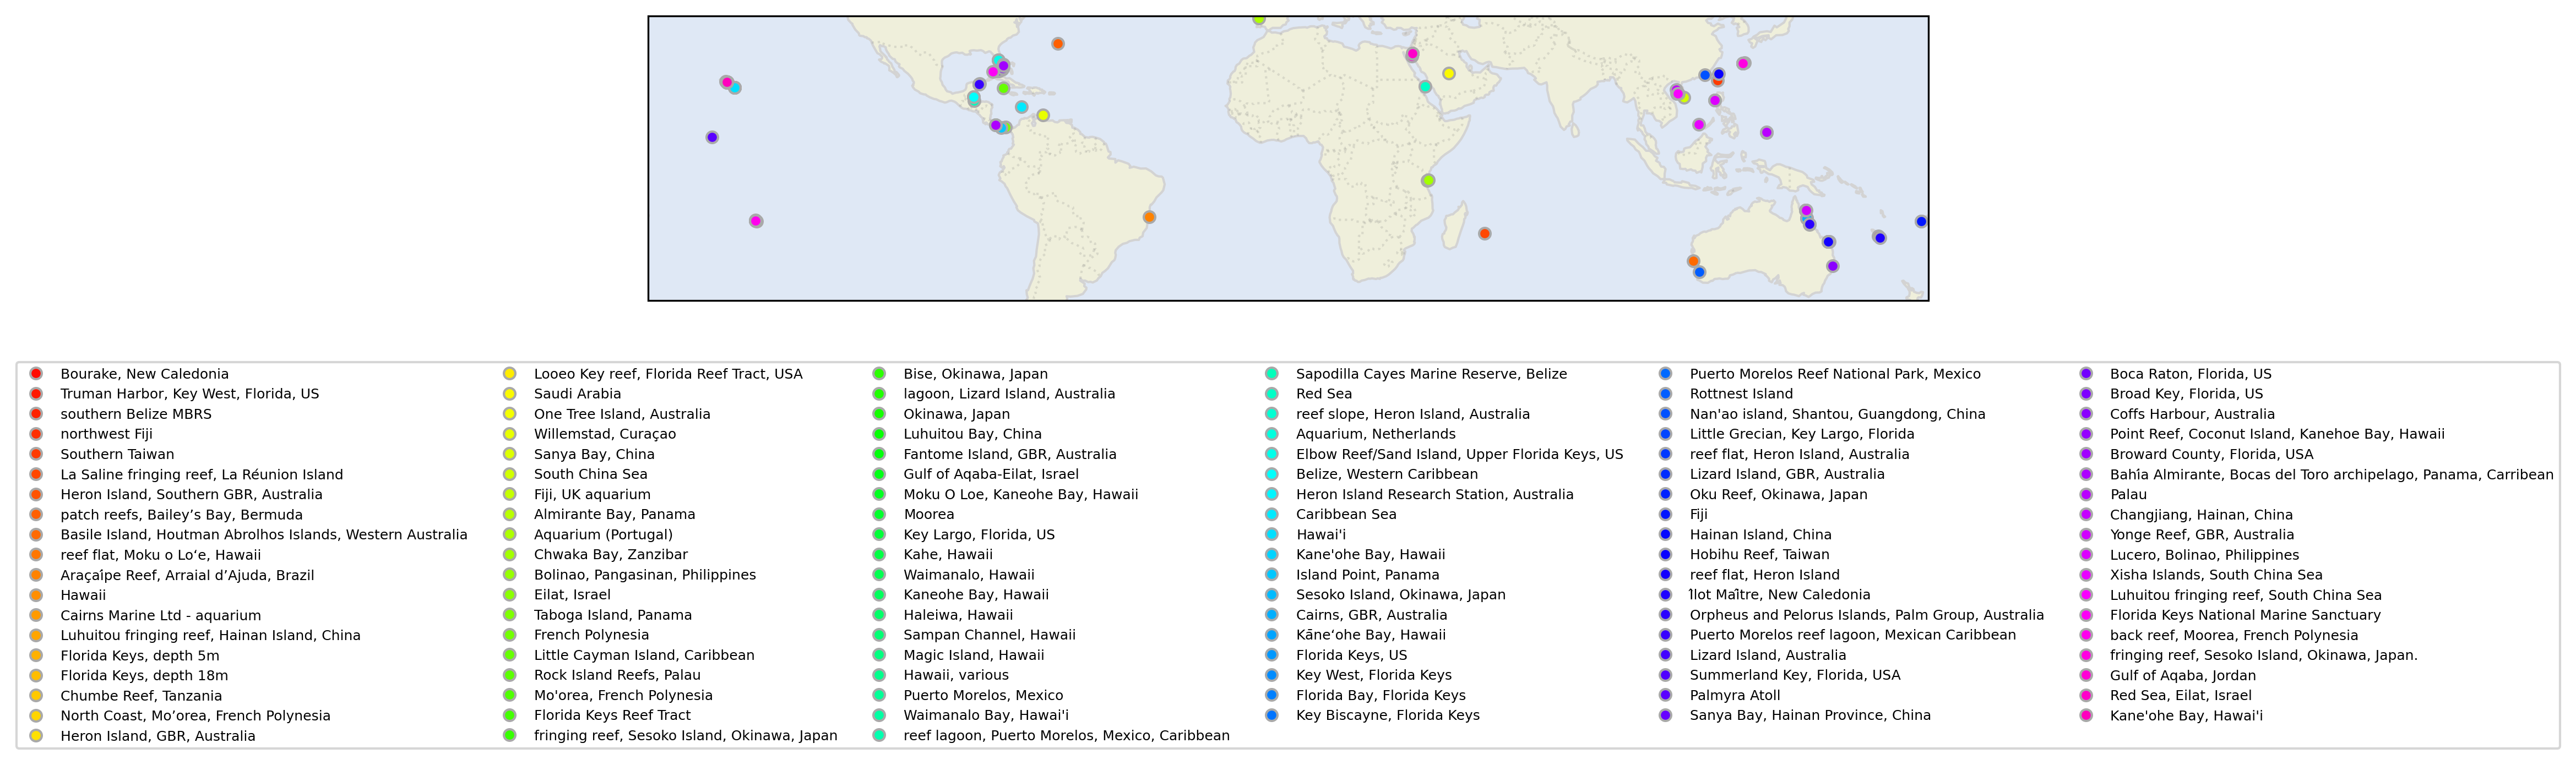

In [14]:
### plot spatial disribution of studies

locs = utils.read_yaml(config.resources_dir / "locations.yaml")   # read locations.yaml
locs_df = pd.DataFrame(locs).T
locs_df = locs_df.dropna()  # drop nans

# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())

# add features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.2)

# add locations with colors
colors = sns.color_palette("hsv", len(locs_df))
locations_to_plot = locs_df.drop_duplicates('location')
for i, (doi, row) in enumerate(locations_to_plot.iterrows()):
    data = locs[doi]
    ax.plot(data["longitude"], data["latitude"], 'o', markeredgecolor='darkgrey', markersize=5, color=colors[i], transform=ccrs.PlateCarree(), label=data["location"])

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -1.6), ncol=len(locs_df)//20, fontsize=6);   # add legend

In [79]:
tropical_areas_df.index

Index([  2,   5,   6,   8,  10,  11,  15,  17,  21,  22,
       ...
       205, 207, 208, 209, 210, 211, 219, 220, 221, 223],
      dtype='int64', length=112)

In [44]:
tropical_areas_df.RLM_CODE.value_counts()

RLM_CODE
6.0    40
5.0    25
4.0    24
7.0    12
8.0    11
Name: count, dtype: int64

In [47]:
tropical_geojson

{'type': 'FeatureCollection',
 'features': [{'id': '2',
   'type': 'Feature',
   'properties': {'ECO_CODE': 20072.0,
    'ECOREGION': 'Amazonia',
    'PROV_CODE': 13.0,
    'PROVINCE': 'North Brazil Shelf',
    'RLM_CODE': 4.0,
    'REALM': 'Tropical Atlantic',
    'ALT_CODE': 64.0,
    'ECO_CODE_X': 72.0,
    'Lat_Zone': 'Tropical'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-41.13011585921021, 0.4731947193748738],
      [-41.03905320219411, 0.4438955612921518],
      [-40.86109061331388, 0.48927861902689074],
      [-40.49111177336897, 0.5098879350093171],
      [-40.38954676444695, 0.49019413514793087],
      [-40.39601663551389, 0.4733147545840666],
      [-41.34201137551963, -1.9947104393512518],
      [-41.67094737307741, -2.8528783486528937],
      [-42.14538076700683, -4.090637419571237],
      [-42.51140081206319, -6.15894644510189],
      [-42.63711302756275, -6.150203683296127],
      [-42.74878651322092, -6.120411613104352],
      [-42.97886490722857, -6.0839

In [108]:
# compute the centroid of each realm by first projecting to a suitable projected CRS
temp_tropical_areas_df = tropical_areas_df.copy()
# Use an equal-area projection to ensure accurate centroid calculation
temp_tropical_areas_df.loc[:,'geometry_projected'] = temp_tropical_areas_df.geometry.to_crs('ESRI:54034')  # World Cylindrical Equal Area
temp_tropical_areas_df.loc[:,'centroid_projected'] = temp_tropical_areas_df['geometry_projected'].centroid
# Convert centroids back to WGS84 (EPSG:4326) for use with lat/lon
temp_tropical_areas_df.loc[:,'centroid'] = temp_tropical_areas_df['centroid_projected'].to_crs('EPSG:4326')
temp_tropical_areas_df.loc[:,'centroid_lat'] = temp_tropical_areas_df['centroid'].y
temp_tropical_areas_df.loc[:,'centroid_lon'] = temp_tropical_areas_df['centroid'].x
# Drop intermediate columns to keep dataframe clean
centroids_df = temp_tropical_areas_df[['RLM_CODE', 'centroid_lat', 'centroid_lon']]
# tropical_areas_df = tropical_areas_df.drop(columns=['geometry_projected', 'centroid_projected'])
# group by realm code and average the lat/lon to get the centroid of each realm
centroids_df = centroids_df.groupby('RLM_CODE').median()

# add column of realm names to centroids df
centroids_df['realm_name'] = centroids_df.index.map(tropical_areas_df.set_index('RLM_CODE')['REALM'].to_dict())
# centroids = dict(centroids_df)
# centroids

In [91]:
centroids_df

,centroid_lat,centroid_lon,realm_name
RLM_CODE,,,
4.0,7.068559,-41.816424,Tropical Atlantic
5.0,3.236420,60.721763,Western Indo-Pacific
6.0,-3.169135,120.500856,Central Indo-Pacific
7.0,-9.279100,-109.692006,Eastern Indo-Pacific
8.0,6.695231,-92.831588,Tropical Eastern Pacific


In [113]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import json

# Create a dataframe for plotting, drop any duplicates in location
locations_to_plot = locs_df.drop_duplicates('location')

# Convert latitude and longitude to numeric (in case they're strings)
locations_to_plot.loc[:, 'latitude'] = pd.to_numeric(locations_to_plot['latitude'])
locations_to_plot.loc[:, 'longitude'] = pd.to_numeric(locations_to_plot['longitude'])

# Create hover text that includes the DOI
locations_to_plot.loc[:, 'hover_text'] = locations_to_plot.index

# Start with an empty figure
fig = go.Figure()

# Convert the GeoDataFrame to GeoJSON format for plotting with Plotly
tropical_geojson = json.loads(tropical_areas_df.to_json())

# Add the tropical areas as choropleth layer (second layer)
fig.add_trace(go.Choropleth(
    geojson=tropical_geojson,
    locations=tropical_areas_df.index,
    z=tropical_areas_df.RLM_CODE,  # Using index for coloring
    colorscale='Viridis',
    marker_opacity=0.3,
    marker_line_width=0.5,
    marker_line_color='white',
    showscale=False,
    hoverinfo='text',
    name='Tropical Marine Ecoregions'
))

# Add the scatter points as the third layer (will be on top)
for location in locations_to_plot['location'].unique():
    subset = locations_to_plot[locations_to_plot['location'] == location]
    fig.add_trace(go.Scattergeo(
        lon=subset['longitude'],
        lat=subset['latitude'],
        text=subset['hover_text'],
        mode='markers',
        marker=dict(size=12, opacity=0.8),
        hovertemplate='%{text}<br>Latitude: %{lat:.4f}<br>Longitude: %{lon:.4f}',
        name=location
    ))

# Add text labels for realms
fig.add_trace(go.Scattergeo(
    lon=centroids_df['centroid_lon'],
    lat=centroids_df['centroid_lat'],
    text=centroids_df['realm_name'],
    mode='text',
    textfont=dict(
        size=12,
        color='#2b2b2b'
    ),
    textposition='middle center',
    hoverinfo='none',
    name='Realm Labels'
))

# Adjust map view to focus on the study regions (-40 to 40 latitude)
fig.update_geos(
    lataxis_range=[-40, 40],
    lonaxis_range=[-180, 180],
    showland=True,
    landcolor='lightgray',
    showocean=True,
    oceancolor='aliceblue',
    showcoastlines=True,
    coastlinecolor='darkgray',
    showframe=True,
    showcountries=True,
    countrycolor='whitesmoke',
    projection_type='natural earth',
    resolution=50
)

# Make layout more compact
fig.update_layout(
    title='Spatial Distribution of Studies in Tropical Marine Ecoregions',
    margin=dict(l=0, r=0, t=30, b=0),
    height=600,
    width=1500,
    legend_title_text='Study Locations',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor='rgba(255,255,255,0.7)'
    )
)

fig.show()

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_17771/1227623729.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Applying reef areas

In [26]:
tropical_areas

,ECO_CODE,ECOREGION,PROV_CODE,PROVINCE,RLM_CODE,REALM,ALT_CODE,ECO_CODE_X,Lat_Zone,geometry
2,20072.0,Amazonia,13.0,North Brazil Shelf,4.0,Tropical Atlantic,64.0,72.0,Tropical,"POLYGON ((-41.13012 0.47319, -41.03905 0.4439,..."
5,20109.0,Andaman and Nicobar Islands,24.0,Andaman,5.0,Western Indo-Pacific,105.0,109.0,Tropical,"POLYGON ((94.17548 14.26051, 94.42859 14.11354..."
6,20110.0,Andaman Sea Coral Coast,24.0,Andaman,5.0,Western Indo-Pacific,106.0,110.0,Tropical,"POLYGON ((96.19677 14.20934, 96.65955 14.62005..."
8,20090.0,Arabian (Persian) Gulf,19.0,Somali/Arabian,5.0,Western Indo-Pacific,92.0,90.0,Tropical,"POLYGON ((54.08128 21.31962, 53.06705 21.19702..."
10,20140.0,Arnhem Coast to Gulf of Carpenteria,32.0,Sahul Shelf,6.0,Central Indo-Pacific,132.0,140.0,Tropical,"POLYGON ((133.3468 -8.85475, 134.83566 -9.4138..."
...,...,...,...,...,...,...,...,...,...,...
211,20117.0,Sunda Shelf/Java Sea,26.0,Sunda Shelf,6.0,Central Indo-Pacific,115.0,117.0,Tropical,"POLYGON ((109.60994 8.48901, 109.713 7.40681, ..."
219,20065.0,Greater Antilles,12.0,Tropical Northwestern Atlantic,4.0,Tropical Atlantic,70.0,65.0,Tropical,"POLYGON ((-82.5383 24.24208, -82.5383 24.24207..."
220,20160.0,Southern Cook/Austral Islands,40.0,Southeast Polynesia,7.0,Eastern Indo-Pacific,155.0,160.0,Tropical,"POLYGON ((-161.87997 -15.01395, -160.8109 -15...."
221,25085.0,Gulf of Guinea South,17.0,Gulf of Guinea,4.0,Tropical Atlantic,186.0,85.0,Tropical,"POLYGON ((13.11166 -1.08534, 13.15398 -1.15744..."


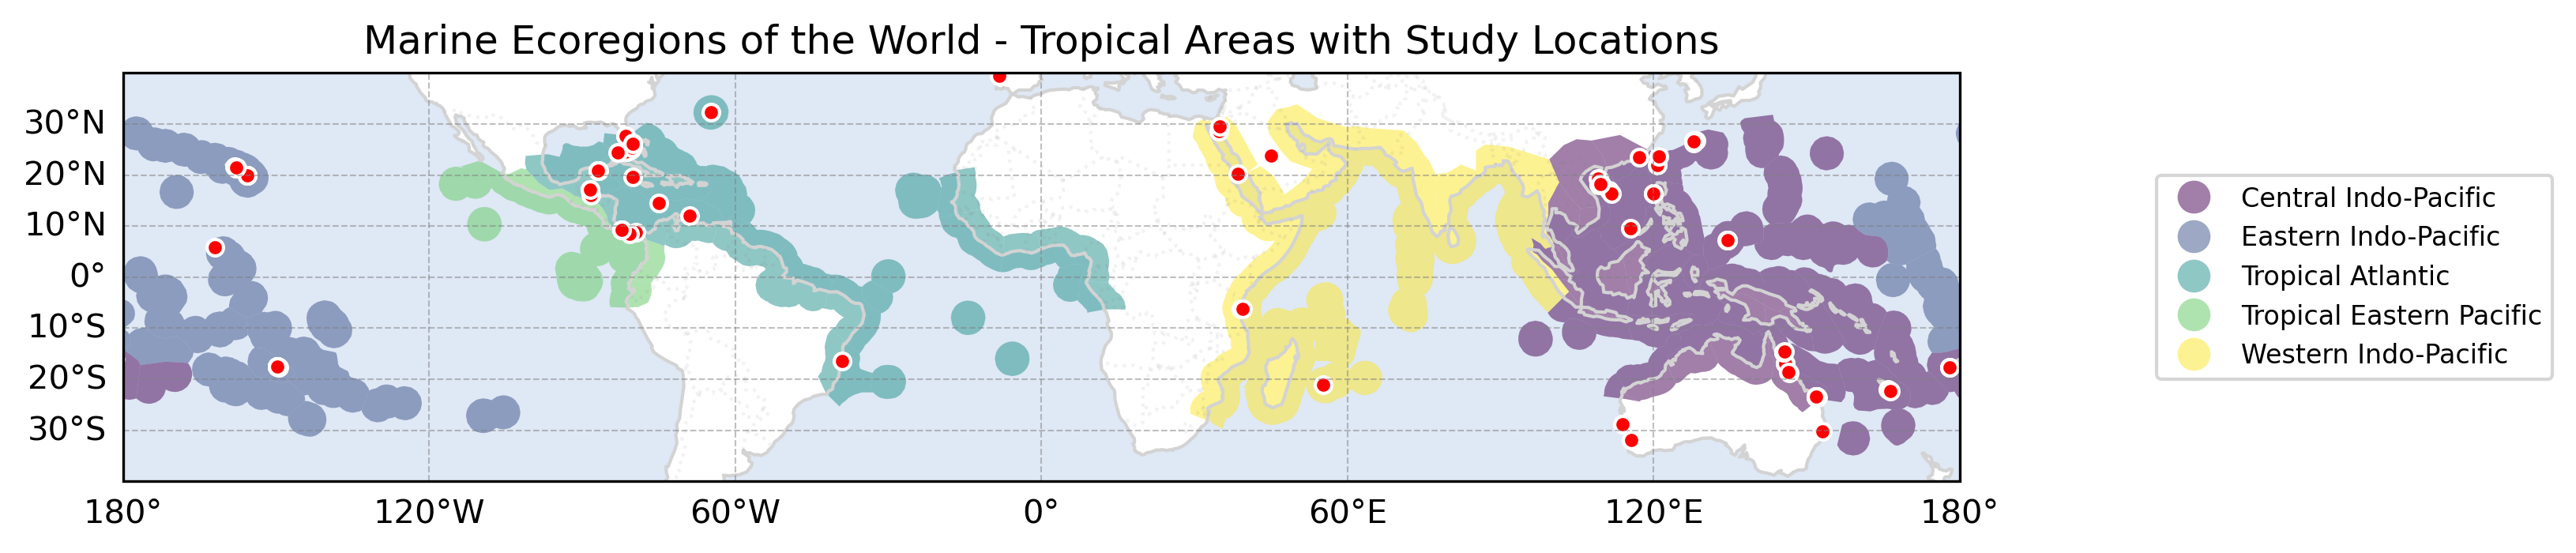

In [80]:
# marine area shapefiles dir
shp_dir_fp = config.climatology_data_dir / "MEOW"

import geopandas as gpd

# read in shapefiles from directory
gdf = gpd.read_file(shp_dir_fp / "meow_ecos.shp")
tropical_areas_df = gdf[gdf['Lat_Zone'] == 'Tropical']


fig, ax = plt.subplots(1, 1, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())
# add features
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray', alpha=0.1)


# plot tropical areas on world map
tropical_areas_df.plot(ax=ax, column='REALM', legend=True, 
                       cmap='viridis', alpha=0.5, 
                       legend_kwds={'bbox_to_anchor': (1.1, 0.5), 
                                    'loc': 'center left',
                                    'fontsize': 8})

# Plot study locations on top of the map
for i, (doi, data) in enumerate(locs_df.iterrows()):
    # Convert coordinates to float if needed
    lat = float(data["latitude"]) if isinstance(data["latitude"], str) else data["latitude"]
    lon = float(data["longitude"]) if isinstance(data["longitude"], str) else data["longitude"]
    
    # Only plot if coordinates are valid
    if pd.notna(lat) and pd.notna(lon):
        ax.plot(lon, lat, 'o', markeredgecolor='white', markersize=5, 
                color='red', transform=ccrs.PlateCarree())

# Add a title
ax.set_title('Marine Ecoregions of the World - Tropical Areas with Study Locations')

# Add gridlines for better orientation
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

In [117]:
locs_df

,latitude,location,longitude,realm
10.1002/ece3.10099,-21.961698,"Bourake, New Caledonia",165.997118,NaN
10.1002/lno.10952,24.55321,"Truman Harbor, Key West, Florida, US",-81.795899,NaN
10.1002/lno.11863,17.189877,southern Belize MBRS,-88.49765,NaN
10.1007/s00227-016-2909-8,-17.713371,northwest Fiji,178.065032,NaN
10.1007/s00227-022-04071-6,21.943,Southern Taiwan,120.7555,NaN
...,...,...,...,...
10.4319/lo.2013.58.1.0388,-17.538843,"back reef, Moorea, French Polynesia",-149.829523,NaN
10.5194/bg-10-6807-2013,26.64515,"fringing reef, Sesoko Island, Okinawa, Japan.",127.864495,NaN
10.5194/bg-17-887-2020,28.692926,"Gulf of Aqaba, Jordan",34.729877,NaN
10.7717/peerj.3749,29.554979,"Red Sea, Eilat, Israel",34.952657,NaN


In [119]:
# get the realm for each location in locs_df based on their falling within a shapefil
from shapely.geometry import Point
for i, (lat, lon) in locs_df[['latitude', 'longitude']].iterrows():
    for j, row in tropical_areas_df.iterrows():
        if row['geometry'].contains(Point(lon, lat)):
            locs_df.loc[i, 'realm'] = row['REALM']
locs_df

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_17771/2605250001.py:6: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Central Indo-Pacific' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



,latitude,location,longitude,realm
10.1002/ece3.10099,-21.961698,"Bourake, New Caledonia",165.997118,Central Indo-Pacific
10.1002/lno.10952,24.55321,"Truman Harbor, Key West, Florida, US",-81.795899,Tropical Atlantic
10.1002/lno.11863,17.189877,southern Belize MBRS,-88.49765,Tropical Atlantic
10.1007/s00227-016-2909-8,-17.713371,northwest Fiji,178.065032,Central Indo-Pacific
10.1007/s00227-022-04071-6,21.943,Southern Taiwan,120.7555,Central Indo-Pacific
...,...,...,...,...
10.4319/lo.2013.58.1.0388,-17.538843,"back reef, Moorea, French Polynesia",-149.829523,Eastern Indo-Pacific
10.5194/bg-10-6807-2013,26.64515,"fringing reef, Sesoko Island, Okinawa, Japan.",127.864495,Central Indo-Pacific
10.5194/bg-17-887-2020,28.692926,"Gulf of Aqaba, Jordan",34.729877,Western Indo-Pacific
10.7717/peerj.3749,29.554979,"Red Sea, Eilat, Israel",34.952657,Western Indo-Pacific


In [116]:
locs_df['realm']

10.1002/ece3.10099           NaN
10.1002/lno.10952            NaN
10.1002/lno.11863            NaN
10.1007/s00227-016-2909-8    NaN
10.1007/s00227-022-04071-6   NaN
                              ..
10.4319/lo.2013.58.1.0388    NaN
10.5194/bg-10-6807-2013      NaN
10.5194/bg-17-887-2020       NaN
10.7717/peerj.3749           NaN
10.7717/peerj.5347           NaN
Name: realm, Length: 124, dtype: float64